In [2]:
import os
import time
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
sns.set_style()

%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format


# Build rm dict 
def build_rm_dict():
    rm_df = pd.read_excel('D:/Thesis_data/Rm.xlsx')
    rm_df['year'] = rm_df['Names Date'].map(lambda x: str(x)[:4])
    rm_df['month'] = rm_df['Names Date'].map(lambda x: str(x)[4:6])
    rm_dict = {}
    for i in range(2005,2019,1):
        rm_dict[i]={}
    for _, row in rm_df.iterrows():
        rm_dict[int(row['year'])][int(row['month'])] = row['Value-Weighted Return-incl. dividends']
    return rm_dict
# Build rf dict 
def build_rf_dict():
    rf_df = pd.read_excel('D:/Thesis_data/Rf.xlsx')
    rf_df['year'] = rf_df['Date (SAS). Last Trading Day of the Month'].map(lambda x: str(x)[:4])
    rf_df['month'] = rf_df['Date (SAS). Last Trading Day of the Month'].map(lambda x: str(x)[4:6])
    rf_dict = {}
    for i in range(2005,2020,1):
        rf_dict[i]={}
    for _, row in rf_df.iterrows():
        rf_dict[int(row['year'])][int(row['month'])] = row['Risk-Free Return Rate (One Month Treasury Bill Rate)']
    return rf_dict
# Read Data
def read_data():
    df = pd.read_excel('D:/Thesis_data/factorData.xlsx')
    df = df.drop('Unnamed: 0', axis=1).reset_index(drop=True)
    df = df.drop(df[df['R']=='C'].index)
    df['size mark'] = 0
    df['book mark'] = 0
    df['btm'] = df['B'] / df['price']
    return df
# Assign Portfolio
def assign_portfolio(df):
    final_result_list = []
    for year in range(2006,2019,1):
        if year == 2006:
            start_month = 7
        else:
            start_month = 1
        year_df = df[df['year'] == year]
        for month in range(start_month,13,1):
            current_df = year_df[year_df['month'] == month]
            current_df = current_df[current_df['B'] >= 0]

            # Assign by market size
            current_df = current_df.sort_values('market size')
            total_market_size = current_df['market size'].sum()
            current_part = 1
            total_part = 5
            current_market_size = 0
            result_list = []
            for _, row in current_df.iterrows():
                current_market_size = current_market_size + row['market size']
                if current_market_size > (total_market_size*current_part/total_part):
                    current_part = current_part + 1
                row['size mark'] = current_part
                result_list.append(row)
            result_df = pd.DataFrame(result_list)
            result_df['size mark'] = result_df['size mark'].apply(lambda x: 5 if x==6 else x)

            # Assign by book to market
            result_df = result_df.sort_values('btm')
            n_company = result_df.shape[0]
            current_part = 1
            total_part = 5
            current_n_company = 0
            result_list=[]
            for _, row in result_df.iterrows():
                current_n_company = current_n_company + 1
                if current_n_company > (n_company*current_part /total_part):
                    current_part = current_part + 1
                row['book mark'] = current_part
                result_list.append(row)
            final_result_list.append(pd.DataFrame(result_list))
    df_assigned = pd.concat(final_result_list).sort_index()
    
    # Assign btm then size
    result_list = []
    df_assigned['book market mark'] = 0
    for year in range(2006,2019,1):
        if year == 2006:
            start_month = 7
        else:
            start_month = 1
        year_df = df_assigned[df_assigned['year'] == year]
        for month in range(start_month,13,1):
            month_df = year_df[year_df['month'] == month]
            for btm_i in range(1,6,1):
                current_df = month_df[month_df['book mark'] == btm_i]
                current_df = current_df.sort_values('market size')
                total_market_size_i = current_df['market size'].sum()
                current_part = 1
                total_part = 5
                current_market_size = 0
                for _, row in current_df.iterrows():
                    current_market_size = current_market_size + row['market size']
                    if current_market_size > (total_market_size_i*current_part/total_part):
                        current_part = current_part + 1
                    row['book market mark'] = str(btm_i)+str(current_part)
                    result_list.append(row)

    df_assigned = pd.DataFrame(result_list)
    return df_assigned

def make_df_for_regression(df_assigned):
    df_assigned['market*R'] = df_assigned['market size'] * df_assigned['R']
    print('Calculating market portfoliio...')
    list_for_size_regression = []
    for year in range(2006,2019,1):
        if year == 2006:
            start_month = 7
        else:
            start_month = 1
        year_df = df_assigned[df_assigned['year'] == year]
        for month in range(start_month,13,1):
            month_df = year_df[year_df['month'] == month]
            for size_i in range(1,6,1):
                current_df = month_df[month_df['size mark'] == size_i]
                row = {}

                R = current_df['market*R'].sum() / current_df['market size'].sum()
                row['R-Rf'] = R - rf_dict[year][month]
                row['Rm-Rf'] = rmrf_dict[year][month]
                row['target'] = size_i
                row['year'] = year
                row['month'] = month
                row['N'] = current_df.shape[0]
                row['tone'] = tone_dict[year][month]
                row['Rsize'] = Rsize_dict[year][month]
                row['Rbtm'] = Rbtm_dict[year][month]
                list_for_size_regression.append(row)
    size_portflio_df = pd.DataFrame(list_for_size_regression)

    print('Calculating btm portfoliio...')
    list_for_btm_regression = []
    for year in range(2006,2019,1):
        if year == 2006:
            start_month = 7
        else:
            start_month = 1
        year_df = df_assigned[df_assigned['year'] == year]
        for month in range(start_month,13,1):
            month_df = year_df[year_df['month'] == month]
            for book_i in range(1,6,1):
                current_df = month_df[month_df['book mark'] == book_i]
                row = {}
                R = current_df['market*R'].sum() / current_df['market size'].sum()
                row['R-Rf'] = R - rf_dict[year][month]
                row['Rm-Rf'] = rmrf_dict[year][month]
                row['target'] = book_i
                row['year'] = year
                row['month'] = month
                row['N'] = current_df.shape[0]
                row['tone'] = tone_dict[year][month]
                row['Rsize'] = Rsize_dict[year][month]
                row['Rbtm'] = Rbtm_dict[year][month]
                list_for_btm_regression.append(row)
    book_portflio_df = pd.DataFrame(list_for_btm_regression)

    print('Calculating btm market portfoliio...')
    list_for_btm_market_regression = []
    for year in range(2006,2019,1):
        if year == 2006:
            start_month = 7
        else:
            start_month = 1
        year_df = df_assigned[df_assigned['year'] == year]
        for month in range(start_month,13,1):
            month_df = year_df[year_df['month'] == month]
            for book_i in range(1,6,1):
                for market_i in range(1,6,1):
                    mark = str(book_i)+str(market_i)
                    current_df = month_df[month_df['book market mark'] == mark]
                    row = {}
                    R = current_df['market*R'].sum() / current_df['market size'].sum()
                    row['R-Rf'] = R - rf_dict[year][month]
                    row['Rm-Rf'] = rmrf_dict[year][month]
                    row['target'] = mark
                    row['year'] = year
                    row['month'] = month
                    row['N'] = current_df.shape[0]
                    row['tone'] = tone_dict[year][month]
                    row['Rsize'] = Rsize_dict[year][month]
                    row['Rbtm'] = Rbtm_dict[year][month]
                    list_for_btm_market_regression.append(row)
    book_market_portflio_df = pd.DataFrame(list_for_btm_market_regression)
    return size_portflio_df, book_portflio_df, book_market_portflio_df

def build_senti_dict(path):
    ticker_df = pd.read_excel('D:/Thesis_data/cik_ticker.xlsx')
    cik_to_ticker_map={}
    for _, row in ticker_df.iterrows():
        cik_to_ticker_map[row['CIK']] = row['Ticker']
    final_dict = {}
    
    senti_dict = pd.read_pickle(path)
    for cik in senti_dict.keys():
        ticker = cik_to_ticker_map[int(cik)]
        final_dict[ticker] = senti_dict[cik]
    return final_dict

def match_senti_score(df, senti_dict, senti_type, vader_score_type='avg'):
    '''
    senti_type = 'vader' or 'li'
    '''
    # 延遲6個月
    
    result_list = []
    column_name = senti_type+' '+vader_score_type
    for _, row in df.iterrows():
        ticker = row['Ticker']
        if row['month'] < 7:
            year = row['year'] - 1
        else:
            year = row['year']
        try:
            if senti_type == 'vader':
                if vader_score_type == 'avg':
                    row[column_name] = senti_dict[ticker][year]['avg']
                elif vader_score_type == 'p_neg':
                    row[column_name] = senti_dict[ticker][year]['p_neg']
                elif vader_score_type == 'short':
                    if senti_dict[ticker][year]['n_words']<250:
                        row['short'] = 1
                    else:
                        row['short'] = 0
            else:
                row[senti_type] = senti_dict[ticker][year]
        except:
            pass
        result_list.append(row)
    return pd.DataFrame(result_list)

def assign_portfolio_by_senti(df, senti_type):
    '''
    senti_type == 'vader' or 'li'
    '''
    df = df.copy()
    senti_type_mark = senti_type + ' mark'
    df[senti_type_mark] = 0
    df_na = df[df[senti_type].isnull()]
    df = df.dropna()
    final_result_list = []
    for year in range(2006,2019,1):
        if year == 2006:
            start_month = 7
        else:
            start_month = 1
        year_df = df[df['year'] == year]
        for month in range(start_month,13,1):
            current_df = year_df[year_df['month'] == month]
            current_df = current_df[current_df['B'] >= 0]
            # Assign by senti
            current_df = current_df.sort_values(senti_type)
            total_size = current_df['market size'].sum()
            current_part = 1
            total_part = 5
            current_size = 0
            result_list=[]
            for _, row in current_df.iterrows():
                if current_size > (total_size * current_part / total_part):
                    current_part = current_part + 1
                row[senti_type_mark] = current_part
                current_size += row['market size']
                result_list.append(row)
            final_result_list.append(pd.DataFrame(result_list))
        result_df = pd.concat([pd.concat(final_result_list), df_na])
    return result_df

def make_df_for_senti(df, senti_type, tone_dict):
    print('Calculating {} portfoliio...'.format(senti_type))
    senti_type_mark = senti_type + ' mark'
    df['market*R'] = df['market size'] * df['R']
    list_for_senti_regression = []
    for year in range(2006,2019,1):
        if year == 2006:
            start_month = 7
        else:
            start_month = 1
        year_df = df[df['year'] == year]
        for month in range(start_month,13,1):
            month_df = year_df[year_df['month'] == month]
            for senti_i in month_df[senti_type_mark].unique():
                current_df = month_df[month_df[senti_type_mark] == senti_i]
                row = {}
                R = current_df['market*R'].sum() / current_df['market size'].sum()
                row['R-Rf'] = R - rf_dict[year][month]
                row['Rm-Rf'] = rmrf_dict[year][month]
                row['target'] = senti_i
                row['year'] = year
                row['month'] = month
                row['N'] = current_df.shape[0]
                row['tone'] = tone_dict[year][month]
                row['Rsize'] = Rsize_dict[year][month]
                row['Rbtm'] = Rbtm_dict[year][month]
                list_for_senti_regression.append(row)
    senti_portflio_df = pd.DataFrame(list_for_senti_regression)
    return senti_portflio_df

def build_portfolio_df():
    tic = time.time()
    # Read data
    rm_dict = build_rm_dict()
    rf_dict = build_rf_dict()
    senti_dict_vader = build_senti_dict('D:/Thesis_data/senti_score.pickle')
    senti_dict_li = build_senti_dict('D:/Thesis_data/li_score.pickle')
    df = read_data()

    print('time used: {}'.format(time.time()-tic))
    print('assign portfolio')
    # assign portfolio
    assigned_df = assign_portfolio(df)

    print('time used: {}'.format(time.time()-tic))
    print('match vader score')
    # match senti score
    df_with_senti_vader = match_senti_score(assigned_df, senti_dict_vader, 'vader')
    df_senti_scores = match_senti_score(df_with_senti_vader, senti_dict_li, 'li')

    print('time used: {}'.format(time.time()-tic))
    print('assign portfolio by vader')
    df_final = assign_portfolio_by_senti(df_senti_scores, 'vader')
    df_final = assign_portfolio_by_senti(df_final, 'li')

    size_portfolio_df, book_portflio_df, book_market_portflio_df = make_df_for_regression(assigned_df)
    vader_portfolio_df = make_df_for_senti(df_final, 'vader')
    li_portfolio_df = make_df_for_senti(df_final, 'li')
    return size_portflio_df, book_portflio_df, book_market_portflio_df, vader_portfolio_df, li_portfolio_df

def build_model(df,n_factors, mark, print_summary=False):
    '''
    df: 已被指定portfolio的df
    n_factors = 1, 3, or 4
    mark_type: 'book mark' or 'size mark' or 'book market mark'
    mark: 
        book and size: 1-5 
        book market mark: '11','12','13',...,'54','55'
    '''
    df = df[df['target'] == mark].dropna()
    y = df['R-Rf']
    if n_factors == 1:
        X = df['Rm-Rf']
    elif n_factors == 3:
        X = df[['Rm-Rf', 'Rsize', 'Rbtm']]
    elif n_factors == 4:
        X = df[['Rm-Rf', 'Rsize', 'Rbtm', 'tone']]
    else:
        print('Error: invalid n_factors')
        return
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    if print_summary:
        print(results.summary())
    return results

def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def excess_return_statistic(port_df, print_mode = False):
    targets = port_df['target'].unique()
    result_list = []
    for target in targets:
        row = {}
        current_df = port_df[port_df['target'] == target]
        r = current_df['R-Rf']
        row['N'] = current_df['N'].mean()
        row['t(mean)'], row['p(mean)'] = ttest_1samp(r,0)
        if print_mode:
            row['N'] = '{:.1f}'.format(row['N'])
            row['mean'] = '{:.4f}{}'.format(r.mean()*100, stars(row['p(mean)']))
            row['t(mean)'] = '({:.4f})'.format(row['t(mean)'])
        else:
            row['mean'] = r.mean()*100
        result_list.append(row)
    statistic_df = pd.DataFrame(result_list)
    statistic_df = statistic_df[['N', 'mean', 't(mean)', 'p(mean)']]
    statistic_df.index = targets
    
    return statistic_df.T
    
def print_statistic(statistic_df, n_factors):
    df = statistic_df.T
    result_list = []
    for name_of_portfolio, row in df.iterrows():
        row['a'] = '{:.4f}{}'.format(row['a'], stars(row['p(a)']))
        row['t(a)'] = '({:.4f})'.format(row['t(a)'])
        row['beta'] = '{:.4f}{}'.format(row['beta'], stars(row['p(beta)']))
        row['t(beta)'] = '({:.4f})'.format(row['t(beta)'])
        if n_factors == 3:
            row['s'] = '{:.4f}{}'.format(row['s'], stars(row['p(s)']))
            row['t(s)'] = '({:.4f})'.format(row['t(s)'])
            row['h'] = '{:.4f}{}'.format(row['h'], stars(row['p(h)']))
            row['t(h)'] = '({:.4f})'.format(row['t(h)'])
        elif n_factors == 4:
            row['s'] = '{:.4f}{}'.format(row['s'], stars(row['p(s)']))
            row['t(s)'] = '({:.4f})'.format(row['t(s)'])
            row['h'] = '{:.4f}{}'.format(row['h'], stars(row['p(h)']))
            row['t(h)'] = '({:.4f})'.format(row['t(h)'])
            row['p'] = '{:.4f}{}'.format(row['p'], stars(row['p(p)']))
            row['t(p)'] = '({:.4f})'.format(row['t(p)'])
        result_list.append(row)
    df = pd.DataFrame(result_list)
    return df.T
    
def print_two_D_param(two_D_statistic, param, marksx, marksy):
    if not param.startswith('t') and param != 'Adj. R':
        p_param = 'p({})'.format(param)
    
    result_list = []
    for marky in marksy:
        row = {}
        for markx in marksx:
            target = str(markx) + str(marky)
            value_param = two_D_statistic.loc[param, target]
            if not param.startswith('t') and param != 'Adj. R':
                value_p_param = two_D_statistic.loc[p_param, target]
                row[markx] = '{:.4f}{}'.format(value_param, stars(value_p_param)).rjust(8)
            elif param.startswith('t'):
                row[markx] = '({:.4f})'.format(value_param).rjust(8)
            else:
                row[markx] = '{:.4f}'.format(value_param).rjust(8)
        result_list.append(row)
    result_df = pd.DataFrame(result_list)
    result_df.columns=marksx
    result_df.index = marksy
    return result_df

def portfolio_mimic(df, n_factors):
    result_list=[]
    targets=df['target'].unique()
    for target in targets:
        row={}
        result = build_model(df, n_factors, target)
        row['a'] = result.params['const']
        row['t(a)'] = result.tvalues['const']
        row['beta'] = result.params['Rm-Rf']
        row['t(beta)'] = result.tvalues['Rm-Rf']
        row['Adj. R'] = result.rsquared_adj * 100
        row['p(a)'] = result.pvalues['const']
        row['p(beta)'] = result.pvalues['Rm-Rf']
        if n_factors == 1:
            result_list.append(row)
        elif n_factors == 3:
            row['s'] = result.params['Rsize']
            row['h'] = result.params['Rbtm']
            row['t(s)'] = result.tvalues['Rsize']
            row['t(h)'] = result.tvalues['Rbtm']
            row['p(s)'] = result.pvalues['Rsize']
            row['p(h)'] = result.pvalues['Rbtm']
            result_list.append(row)
        elif n_factors == 4:
            row['s'] = result.params['Rsize']
            row['h'] = result.params['Rbtm']
            row['p'] = result.params['tone']
            row['t(s)'] = result.tvalues['Rsize']
            row['t(h)'] = result.tvalues['Rbtm']
            row['t(p)'] = result.tvalues['tone']
            row['p(s)'] = result.pvalues['Rsize']
            row['p(h)'] = result.pvalues['Rbtm']
            row['p(p)'] = result.pvalues['tone']
            result_list.append(row)
    statistic_df = pd.DataFrame(result_list)
    if n_factors == 1:
        statistic_df = statistic_df[['a','t(a)','beta','t(beta)','Adj. R','p(a)','p(beta)']]
    elif n_factors == 3:
        statistic_df = statistic_df[['a','t(a)','beta','t(beta)','s','t(s)','h','t(h)',
                                     'Adj. R','p(a)','p(beta)','p(s)','p(h)']]
    elif n_factors == 4:
        statistic_df = statistic_df[['a','t(a)','beta','t(beta)','s','t(s)','h','t(h)','p','t(p)',
                                     'Adj. R','p(a)','p(beta)','p(s)','p(h)','p(p)']]
    statistic_df.index = targets
    return statistic_df.T

def mimic_and_print(portfolio_df, n_factors, dim_2=False, param='a',marksx=range(1,6,1),marksy=range(1,6,1)):
    statistic_df = portfolio_mimic(portfolio_df, n_factors)
    if dim_2:
        return print_two_D_param(statistic_df,param,marksx,marksy)
    else:
        return print_statistic(statistic_df, n_factors)

def match_senti_score_vader(df, senti_dict):
    '''
    senti_type = 'vader' or 'li'
    '''
    # 延遲6個月
    
    result_list = []
    for _, row in df.iterrows():
        ticker = row['Ticker']
        if row['month'] < 7:
            year = row['year'] - 1
        else:
            year = row['year']
        try:
            row['vader avg'] = senti_dict[ticker][year]['avg']
            row['vader p_neg'] = senti_dict[ticker][year]['p_neg']
            row['vader p_pos'] = senti_dict[ticker][year]['p_pos']
            row['vader n_words'] = senti_dict[ticker][year]['n_words']
        except:
            pass
        result_list.append(row)
    return pd.DataFrame(result_list)

def main():
    size_portflio_df, book_portflio_df, book_market_portflio_df, vader_portfolio_df, li_portfolio_df = build_portfolio_df()

Rsize_dict = pd.read_pickle('D:/Thesis_data/smb_dict_fama.pickle')
Rbtm_dict = pd.read_pickle('D:/Thesis_data/hml_dict_fama.pickle')
rmrf_dict = pd.read_pickle('D:/Thesis_data/rmrf_dict_fama.pickle')
rf_dict = pd.read_pickle('D:/Thesis_data/rf_dict_fama.pickle')
senti_dict_vader = build_senti_dict('D:/Thesis_data/vader_score_dict_200106.pickle')
senti_dict_li = build_senti_dict('D:/Thesis_data/li_score.pickle')
tone_dict = pd.read_pickle('D:/Thesis_data/tone_dict200107.pickle')


# Test match different senti scores

In [4]:
df_path = 'D:/Thesis_data/df_final200107.pickle'
df = pd.read_pickle(df_path)

li_port = make_df_for_senti(df, 'li', tone_dict)
avg_port = make_df_for_senti(df, 'vader avg', tone_dict)

p_pos_port = make_df_for_senti(df, 'vader p_pos', tone_dict)
p_neg_port = make_df_for_senti(df, 'vader p_neg', tone_dict)
p_pos_sentence_port = make_df_for_senti(df, 'vader p_pos_sentence', tone_dict)
p_neg_sentence_port = make_df_for_senti(df, 'vader p_neg_sentence', tone_dict)
avg_neg_port = make_df_for_senti(df, 'vader neg avg', tone_dict)
avg_pos_port = make_df_for_senti(df, 'vader pos avg', tone_dict)

# 2D
avg_size_port = make_df_for_senti(df, 'avg size', tone_dict)
p_neg_size_port = make_df_for_senti(df, 'p_neg size', tone_dict)
p_neg_sentence_size_port = make_df_for_senti(df, 'p_neg_sentence size', tone_dict)

############################## aborted portfolio ##############################
# li_size_port = make_df_for_senti(df, 'li size')
# n_words_port = make_df_for_senti(df, 'vader n_words')
# not_nu_port = make_df_for_senti(df, 'not nu')
###############################################################################

# Fama-French portfolio
size_port = make_df_for_senti(df, 'market size', tone_dict)
btm_port = make_df_for_senti(df, 'btm', tone_dict)

Calculating li portfoliio...
Calculating vader avg portfoliio...
Calculating vader p_pos portfoliio...
Calculating vader p_neg portfoliio...
Calculating vader p_pos_sentence portfoliio...
Calculating vader p_neg_sentence portfoliio...
Calculating vader neg avg portfoliio...
Calculating vader pos avg portfoliio...
Calculating avg size portfoliio...
Calculating p_neg size portfoliio...
Calculating p_neg_sentence size portfoliio...
Calculating market size portfoliio...
Calculating btm portfoliio...


In [96]:
t = mimic_and_print(p_pos_sentence_port, 3)
t[[1,2,3,4,5]]

,1,2,3,4,5
a,0.0038***,0.0054***,0.0049***,0.0094***,0.0071***
t(a),(2.6332),(4.4311),(4.0912),(8.6322),(6.9096)
beta,1.0546***,1.0976***,1.0693***,0.9268***,0.9405***
t(beta),(28.6505),(35.8328),(35.4153),(33.9272),(36.2229)
s,0.2276***,0.1428**,0.0958*,-0.0902*,0.0431
t(s),(3.4189),(2.5782),(1.7545),(-1.8255),(0.9185)
h,-0.1114*,-0.2103***,-0.1768***,-0.0825*,-0.1900***
t(h),(-1.9648),(-4.4561),(-3.8018),(-1.9611),(-4.7504)
Adj. R,87.4597,91.1585,90.8753,89.6952,91.0418
p(a),0.0094,0.0000,0.0001,0.0000,0.0000


In [10]:
df.columns

Index(['Ticker', 'market size', 'R', 'price', 'year', 'month', 'B',
       'size mark', 'book mark', 'btm', 'book market mark', 'vader', 'li',
       'vader mark', 'li mark', 'market*R', 'vader avg', 'short',
       'vader p_neg', 'vader p_pos', 'vader n_words', 'vader p_neg mark',
       'vader p_pos mark', 'vader avg mark', 'vader n_words mark',
       'market size mark', 'btm mark', 'vader p_neg_sentence',
       'vader p_pos_sentence', 'vader p_neg_sentence mark',
       'vader p_pos_sentence mark', 'not nu', 'not nu mark', 'avg size mark',
       'p_pos size mark', 'p_pos_sentence size mark', 'p_neg size mark',
       'p_neg_sentence size mark', 'vader neg avg', 'vader pos avg',
       'vader pos avg mark', 'vader neg avg mark'],
      dtype='object')

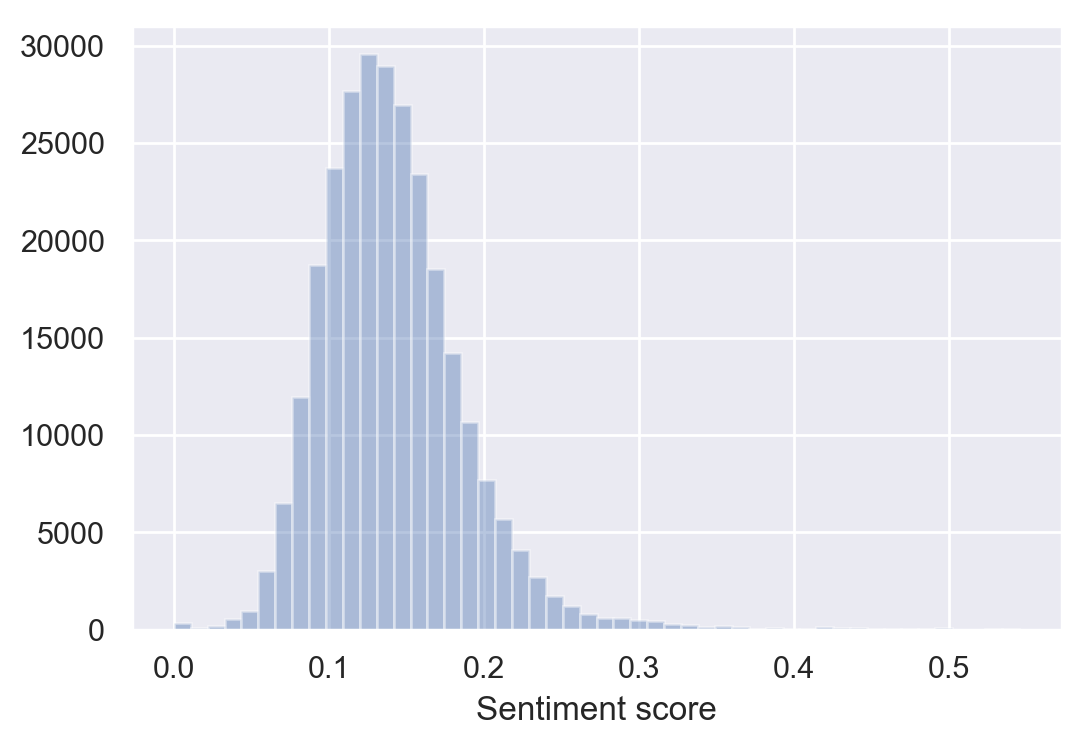

In [72]:
plt.figure(dpi=200)
sns.set(color_codes=True)

sns.distplot(df['vader p_neg_sentence'], kde=False, axlabel='Sentiment score')

In [154]:
mimic_and_print(p_neg_size_port,4,True)

,1,2,3,4,5
1,0.0081***,0.0055***,0.0041***,0.0034**,0.0014
2,0.0089***,0.0058***,0.0050***,0.0026*,0.0032
3,0.0089***,0.0048**,0.0086***,0.0067***,0.0045**
4,0.0108***,0.0046,0.0063**,0.0056,0.0011
5,0.0066,0.0080*,0.0188***,0.0051,0.0028


In [25]:
t = excess_return_statistic(avg_port, True)
t[[1,2,3,4,5]]

,1,2,3,4,5
N,509.8,460.1,332.6,296.2,224.4
mean,1.0784**,1.2086***,1.5895***,1.3859***,1.3644***
t(mean),(2.4830),(3.1449),(4.2597),(4.1194),(4.0897)
p(mean),0.0141,0.0020,0.0000,0.0001,0.0001


In [5]:
avg_port

,N,R-Rf,Rbtm,Rm-Rf,Rsize,month,target,tone,year
0,474,-0.0202,0.0294,-0.0078,-0.0407,7,1,-0.0195,2006
1,149,0.0113,0.0294,-0.0078,-0.0407,7,5,-0.0195,2006
2,472,-0.0286,0.0294,-0.0078,-0.0407,7,2,-0.0195,2006
3,262,-0.0201,0.0294,-0.0078,-0.0407,7,4,-0.0195,2006
4,212,-0.0072,0.0294,-0.0078,-0.0407,7,3,-0.0195,2006
5,469,0.0343,-0.0171,0.0203,0.0090,8,1,-0.0052,2006
6,152,0.0233,-0.0171,0.0203,0.0090,8,5,-0.0052,2006
7,475,0.0208,-0.0171,0.0203,0.0090,8,2,-0.0052,2006
8,259,0.0399,-0.0171,0.0203,0.0090,8,4,-0.0052,2006
9,220,0.0144,-0.0171,0.0203,0.0090,8,3,-0.0052,2006


In [27]:
df.columns

Index(['Ticker', 'market size', 'R', 'price', 'year', 'month', 'B',
       'size mark', 'book mark', 'btm', 'book market mark', 'vader', 'li',
       'vader mark', 'li mark', 'market*R', 'vader avg', 'short',
       'vader p_neg', 'vader p_pos', 'vader n_words', 'vader p_neg mark',
       'vader p_pos mark', 'vader avg mark', 'vader n_words mark',
       'market size mark', 'btm mark', 'vader p_neg_sentence',
       'vader p_pos_sentence', 'vader p_neg_sentence mark',
       'vader p_pos_sentence mark', 'not nu', 'not nu mark', 'avg size mark',
       'p_pos size mark', 'p_pos_sentence size mark', 'p_neg size mark',
       'p_neg_sentence size mark', 'vader neg avg', 'vader pos avg',
       'vader pos avg mark', 'vader neg avg mark'],
      dtype='object')

In [77]:

df[df['vader p_pos_sentence mark'] == 1]['vader p_pos_sentence'].mean()

0.4120513429885233

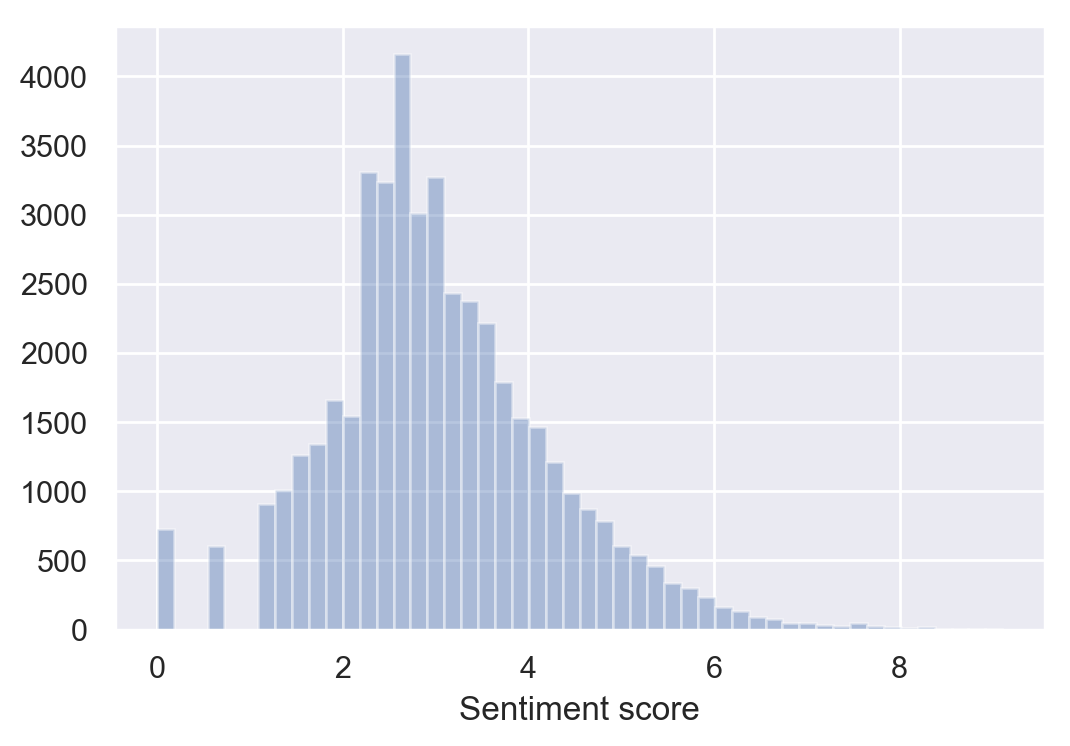

In [9]:
result_list = []
for ticker, senti_dict in senti_dict_vader.items():
    for year, year_dict in senti_dict.items():
        if year_dict['n_words'] > 250:
            result_list.append(senti_dict_li[ticker][year])
        
plt.figure(dpi=200)
sns.set(color_codes=True)
sns.distplot(pd.Series(result_list).dropna(), kde=False, axlabel='Sentiment score')

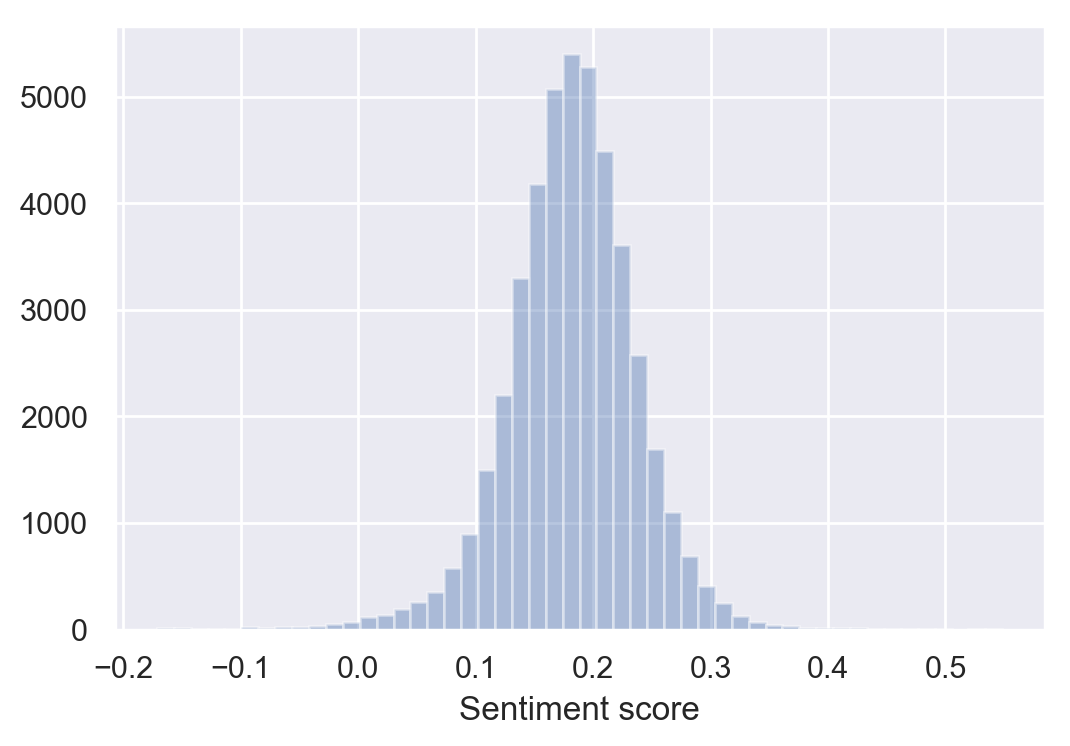

In [6]:
result_list = []
for ticker, senti_dict in senti_dict_vader.items():
    for year, year_dict in senti_dict.items():
        if year_dict['n_words'] > 250:
            result_list.append(year_dict['avg'])
        
plt.figure(dpi=200)
sns.set(color_codes=True)
sns.distplot(pd.Series(result_list).dropna(), kde=False, axlabel='Sentiment score')

In [24]:
senti_dict_vader['BBT'][2003]

{'avg': nan,
 'p_pos': 0,
 'p_neg': 0,
 'p_neu': 0,
 'n_pos': 0,
 'n_neg': 0,
 'n_neu': 0,
 'n_sentence': 0,
 'n_words': 0}

# test insample factors

In [2]:
#Rsize_dict = pd.read_pickle('D:/Thesis_data/insample_factors/smb_dict.pickle')
#Rbtm_dict = pd.read_pickle('D:/Thesis_data/insample_factors/hml_dict.pickle')
rm_dict = pd.read_pickle('D:/Thesis_data/insample_factors/rm_dict.pickle')
rf_dict = pd.read_pickle('D:/Thesis_data/rf_dict_fama.pickle')
rmrf_dict = {}
for year, year_dict in rm_dict.items():
    rmrf_dict[year] = {}
    for month, rm in year_dict.items():
        rmrf_dict[year][month] = rm - rf_dict[year][month]
#rmrf_dict = pd.read_pickle('D:/Thesis_data/rmrf_dict_fama.pickle')

senti_dict_vader = build_senti_dict('D:/Thesis_data/vader_score_dict_200106.pickle')
senti_dict_li = build_senti_dict('D:/Thesis_data/li_score.pickle')
avg_tone_dict = pd.read_pickle('D:/Thesis_data/insample_factors/avg_tone_dict0109.pickle')
pos_tone_dict = pd.read_pickle('D:/Thesis_data/insample_factors/pos_tone_dict0109.pickle')
neg_tone_dict = pd.read_pickle('D:/Thesis_data/insample_factors/neg_tone_dict0109.pickle')

In [3]:
df_path = 'D:/Thesis_data/df_final200109.pickle'
df = pd.read_pickle(df_path)

li_port = make_df_for_senti(df, 'li', tone_dict=avg_tone_dict)
avg_port = make_df_for_senti(df, 'vader avg', tone_dict=avg_tone_dict)

p_pos_port = make_df_for_senti(df, 'vader p_pos', tone_dict=avg_tone_dict)
p_neg_port = make_df_for_senti(df, 'vader p_neg', tone_dict=avg_tone_dict)
p_pos_sentence_port = make_df_for_senti(df, 'vader p_pos_sentence', tone_dict=pos_tone_dict)
p_neg_sentence_port = make_df_for_senti(df, 'vader p_neg_sentence', tone_dict=neg_tone_dict)
avg_neg_port = make_df_for_senti(df, 'vader neg avg', tone_dict=avg_tone_dict)
avg_pos_port = make_df_for_senti(df, 'vader pos avg', tone_dict=avg_tone_dict)

# 2D
avg_size_port = make_df_for_senti(df, 'avg size', tone_dict=avg_tone_dict)
p_neg_size_port = make_df_for_senti(df, 'p_neg size', tone_dict=avg_tone_dict)
p_neg_sentence_size_port = make_df_for_senti(df, 'p_neg_sentence size', tone_dict=avg_tone_dict)

############################## aborted portfolio ##############################
# li_size_port = make_df_for_senti(df, 'li size')
# n_words_port = make_df_for_senti(df, 'vader n_words')
# not_nu_port = make_df_for_senti(df, 'not nu')
###############################################################################

# Fama-French portfolio
size_port = make_df_for_senti(df, 'market size', tone_dict=avg_tone_dict)
btm_port = make_df_for_senti(df, 'btm', tone_dict=avg_tone_dict)
ff_2D_port_avg_tone = make_df_for_senti(df, 'book market', avg_tone_dict)
ff_2D_port_pos_tone = make_df_for_senti(df, 'book market', pos_tone_dict)
ff_2D_port_neg_tone = make_df_for_senti(df, 'book market', neg_tone_dict)

Calculating li portfoliio...
Calculating vader avg portfoliio...
Calculating vader p_pos portfoliio...
Calculating vader p_neg portfoliio...
Calculating vader p_pos_sentence portfoliio...
Calculating vader p_neg_sentence portfoliio...
Calculating vader neg avg portfoliio...
Calculating vader pos avg portfoliio...
Calculating avg size portfoliio...
Calculating p_neg size portfoliio...
Calculating p_neg_sentence size portfoliio...
Calculating market size portfoliio...
Calculating btm portfoliio...
Calculating book market portfoliio...
Calculating book market portfoliio...
Calculating book market portfoliio...


In [114]:
t = mimic_and_print(ff_2D_port_avg_tone, 3, True, 'Adj. R')
t[[1,2,3,4,5]].applymap(float).sum().sum()/25


73.683204

In [4]:
t = mimic_and_print(ff_2D_port_avg_tone, 4, True, 'Adj. R')
t[[1,2,3,4,5]].applymap(float).sum().sum()/25

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


74.677412

In [33]:
t = mimic_and_print(ff_2D_port_neg_tone, 4, True, 'Adj. R')
t[[1,2,3,4,5]]

,1,2,3,4,5
1,93.4610,95.6353,94.3720,93.1707,80.2545
2,91.1513,90.4527,85.9693,70.8608,67.7986
3,83.8611,86.0874,82.5148,72.8907,36.5763
4,66.4598,73.9465,69.1709,63.1195,32.3368
5,56.7184,57.1162,66.3203,64.5058,86.3173


In [117]:
t = mimic_and_print(avg_port, 4)
np.mean(t[[1,2,3,4,5]].loc['Adj. R',:])

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


94.92234530338007

In [20]:
t = excess_return_statistic(li_port, True)
t[[1,2,3,4,5]]

,1,2,3,4,5
N,255.2,391.8,391.8,391.9,392.3
mean,1.3764***,1.3962***,1.6494***,1.2873***,1.0780***
t(mean),(3.7090),(3.6916),(4.4264),(3.3941),(3.0672)
p(mean),0.0003,0.0003,0.0000,0.0009,0.0026


In [6]:
df.head()

,Ticker,market size,R,price,year,month,B,size mark,book mark,btm,...,not nu mark,avg size mark,p_pos size mark,p_pos_sentence size mark,p_neg size mark,p_neg_sentence size mark,vader neg avg,vader pos avg,vader pos avg mark,vader neg avg mark
180498,STE,"1,525,142.0800",0.0136,23.1700,2006,7,10.9118,1,3,0.4709,...,4,11,11,31,51,51,-0.5970,0.5387,5,1
122316,MU,"11,378,844.7900",0.0352,15.5900,2006,7,9.4885,2,4,0.6086,...,3,12,12,32,22,42,-0.5311,0.4628,2,1
228626,ERIE,"2,872,363.9500",-0.0402,49.5500,2006,7,18.8135,1,3,0.3797,...,3,11,11,11,51,51,-0.5206,0.4307,1,1
183931,UNAM,"64,737.7900",0.0844,11.5810,2006,7,8.8053,1,5,0.7603,...,4,11,11,11,51,51,-0.4993,0.4455,1,1
303438,DYAX,"137,155.2000",0.0680,3.1400,2006,7,1.0765,1,2,0.3428,...,3,11,21,11,51,51,-0.4930,0.4645,2,1


In [7]:
df.columns

Index(['Ticker', 'market size', 'R', 'price', 'year', 'month', 'B',
       'size mark', 'book mark', 'btm', 'book market mark', 'vader', 'li',
       'vader mark', 'li mark', 'market*R', 'vader avg', 'short',
       'vader p_neg', 'vader p_pos', 'vader n_words', 'vader p_neg mark',
       'vader p_pos mark', 'vader avg mark', 'vader n_words mark',
       'market size mark', 'btm mark', 'vader p_neg_sentence',
       'vader p_pos_sentence', 'vader p_neg_sentence mark',
       'vader p_pos_sentence mark', 'not nu', 'not nu mark', 'avg size mark',
       'p_pos size mark', 'p_pos_sentence size mark', 'p_neg size mark',
       'p_neg_sentence size mark', 'vader neg avg', 'vader pos avg',
       'vader pos avg mark', 'vader neg avg mark'],
      dtype='object')